# Quadrotor SINDy Notebook

## System Dynamics - 3D

![](3D_QUAD_DRAWING.png "Example")

### Planar Quadrotor

$$\ddot{y} = \frac{-u_{1}}{m} \sin{\phi}$$
$$\ddot{z} = -g + \frac{-u_{1}}{m} \cos{\phi}$$
$$\ddot{\phi} = \frac{u_{2}}{I_{xx}}$$

![](3D_QUAD_DRAWING.png "Example")

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
import pysindy as ps
from scipy.integrate import odeint

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from mpl_toolkits.mplot3d import axes3d
import math

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook', 'grid'])
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

In [90]:
def load_data(file_dir):
    print('loading data..')
    df = pd.read_csv(file_dir) #loading pre-data
    print('data loaded')
    return df

In [91]:
def organize_data(df):
    t = df[df.columns[0]]
    y = df[df.columns[1]]
    z = df[df.columns[2]]
    phi = df[df.columns[3]]
    v = df[df.columns[4]]
    w = df[df.columns[5]]
    phi_dot = df[df.columns[6]]
    u1 = df[df.columns[7]]
    u2 = df[df.columns[8]]
    y_ref = df[df.columns[9]]
    z_ref = df[df.columns[10]]
    return t, y, z, phi, v, w, phi_dot, u1, u2, y_ref, z_ref

           
def viz_data(df):
        pass

In [93]:
# load data
file_dir = '../DATA FOR SINDY/all_out.csv'
df = load_data(file_dir)
df.head()

# organize data
#t, y, z, phi, v, w, phi_dot, u1, u2, y_ref, z_ref = organize_data(df)

loading data..
data loaded


,0,1.8,0.1,0.2,0.3,0.4,1.89307922061358,-0.00684761918580245,0.5,1.8.1,0.6,0.7,0.707106781186548,0.707106781186547
0,1.200286e-07,1.800035,-0.001370,0.000048,0.007071,-0.273905,1.893060,-0.005781,0.000035,1.800035,0.007064,0.007064,0.707107,0.707107
1,1.901753e-06,1.800141,-0.005265,0.000377,0.014140,-0.505161,1.893064,-0.004680,0.000141,1.800141,0.014135,0.014135,0.707107,0.707107
2,9.403862e-06,1.800318,-0.011253,0.001229,0.021207,-0.692369,1.893075,-0.003576,0.000318,1.800318,0.021206,0.021206,0.707107,0.707107
3,2.888471e-05,1.800566,-0.018891,0.002801,0.028266,-0.835425,1.893109,-0.002500,0.000565,1.800565,0.028277,0.028277,0.707107,0.707107
4,6.833927e-05,1.800883,-0.027746,0.005245,0.035310,-0.935408,1.893184,-0.001476,0.000884,1.800884,0.035348,0.035348,0.707107,0.707107


In [38]:
t  = pd.read_csv('../DATA FOR SINDY/time.csv') #loading pre-data
t = t.to_numpy()

In [39]:
y = df[df.columns[0]]
z = df[df.columns[1]]
phi = df[df.columns[2]]
v = df[df.columns[3]]
w = df[df.columns[4]]
phi_dot = df[df.columns[5]]
u1 = df[df.columns[6]]
u2 = df[df.columns[7]]
y_ref = df[df.columns[8]]
z_ref = df[df.columns[9]]

In [40]:
dt = t[1] - t[0]
dt = dt[0]
dt

0.01

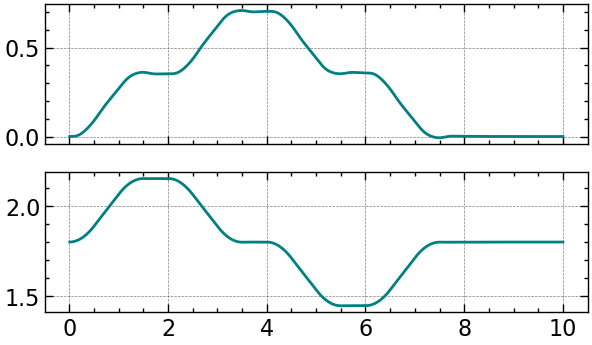

In [63]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 4))
axs[0].plot(t,y, color= 'teal')
axs[1].plot(t,z, color= 'teal')
plt.show()

Text(0, 0.5, '$z$')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


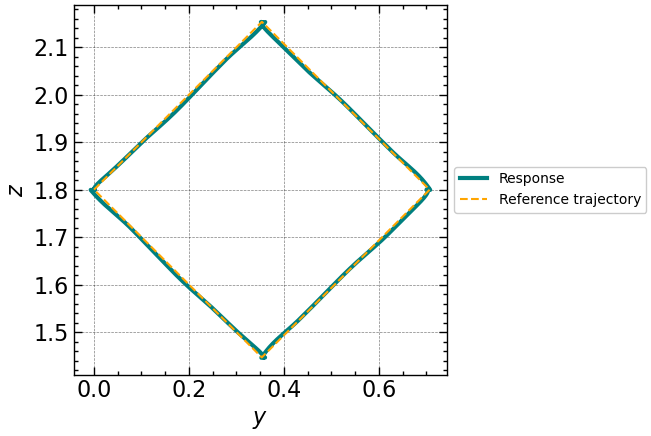

In [42]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(19, 6))
axs.plot(y,z, color= 'teal', lw=3, label='Response')
axs.plot(y_ref, z_ref,
         color='orange',
         lw=1.5, ls='--',
         label='Reference trajectory')
axs.set_aspect('equal')
box = axs.get_position()
axs.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
axs.set_xlabel(r'$y$')
axs.set_ylabel(r'$z$')

In [43]:
X = np.stack((y, z, phi, v, w, phi_dot), axis=-1)
U = np.stack((u1, u2), axis=-1)

In [44]:
X.shape

(1000, 6)

In [45]:
U.shape

(1000, 2)

In [46]:
differentiation_method = ps.FiniteDifference(order=1)

In [47]:
poly_library = ps.PolynomialLibrary(degree=1)
fourier_library = ps.FourierLibrary()

n_inputs = 8
n_libs = 2
# Initialize the default inputs, i.e. each library
# uses all the input variables, (8 inputs and 2 libraries here)
inputs_temp = np.tile(np.arange(0,n_inputs, 1), n_libs)
inputs_per_library = np.reshape(inputs_temp, (n_libs, n_inputs))
print(inputs_per_library)

[[0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]]


In [48]:
# Don't use the phi inputs for generating the polynomila library
inputs_per_library[0, 2] = 1

# only use phi in the Fourier library
inputs_per_library[1, 0] = 2
inputs_per_library[1, 1] = 2
inputs_per_library[1, 2] = 2
inputs_per_library[1, 3] = 2
inputs_per_library[1, 4] = 2
inputs_per_library[1, 5] = 2
inputs_per_library[1, 6] = 2
inputs_per_library[1, 7] = 2

print(inputs_per_library)

[[0 1 1 3 4 5 6 7]
 [2 2 2 2 2 2 2 2]]


In [49]:
# Tensor all the polynomial and Fourier library terms together
# and tensor all the Fourier and Custom library terms together.
tensor_array = [[1, 1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

In [50]:
optimizer = ps.SR3(threshold=0.44,
                thresholder="l1",
                max_iter=10000,
                tol=1e-1)
feature_names = ["y", "z", "phi", "y'", "z'", "phi'", "u1", "u2"]

model = ps.SINDy(differentiation_method=differentiation_method,
            feature_library=generalized_library,
            optimizer=optimizer,
            feature_names=feature_names)

model.fit(X, u=U, t=dt, ensemble=True)

SINDy(differentiation_method=FiniteDifference(order=1),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x000001DC04172520>,
      feature_names=['y', 'z', 'phi', "y'", "z'", "phi'", 'u1', 'u2'],
      optimizer=SR3(max_iter=10000, threshold=0.44, thresholder='l1', tol=0.1))

In [51]:
model.print()

(y)' = 1.000 y'
(z)' = 1.000 z'
(phi)' = 0.993 phi' cos(1 phi)
(y')' = -5.549 u1 sin(1 phi)
(z')' = -9.811 1 + 5.556 u1 cos(1 phi)
(phi')' = 4000.000 u2


In [52]:
x_dot_test_predicted = model.predict(X, u=U)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(X, t=dt)

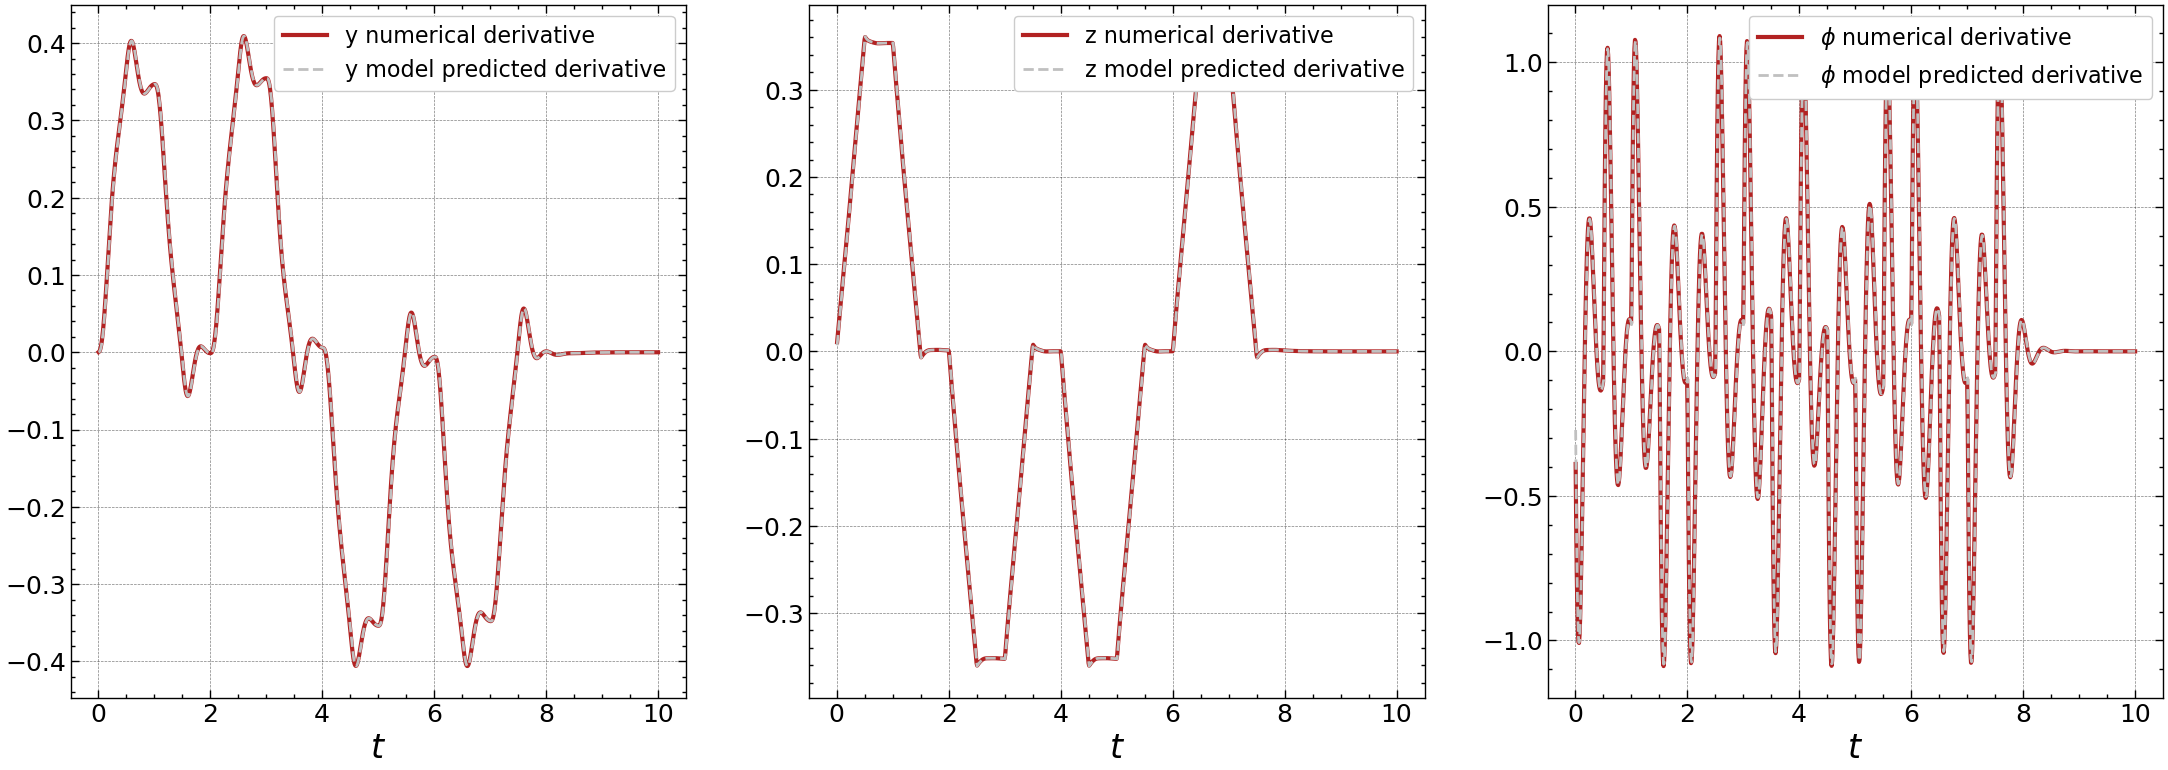

In [60]:
feature_name = ["y", "z", r"$\phi$"]
plt.figure(figsize=(3*9, 3*3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t, x_dot_test_computed[:, i],
             color='firebrick',
             linewidth= 3,
             label=feature_name[i] + ' numerical derivative')
    plt.plot(t, x_dot_test_predicted[:, i],
             color='silver',
             lw = 2,
             linestyle = '--', label=feature_name[i] + ' model predicted derivative')
    plt.grid(True)
    plt.xlabel(r"$t$", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=12)
    
    plt.legend()
fig.show()

### Check Ensemble Results

In [54]:
ensemble_coefs = model.coef_list

# Get average and standard deviation of the ensemble model coefficients
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)
mean_ensemble.shape

(6, 26)

In [55]:
std_ensemble.shape

(6, 26)

In [56]:
library_ensemble_coefs = model.coef_list

# Get average and standard deviation of the library ensemble model coefficients
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)